# Advertisement Classification
### To predict whether a comment is ad or not

### Importing Packages

In [36]:
## import all neccessary packages
import numpy as np
import pandas as pd
import regex as re

#NLP Packages
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Packages for splitting, evaluating,visualization, bagofwords and hyperparameter tuning

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, confusion_matrix, auc, roc_curve

#Classifier Packages
from sklearn.tree import ExtraTreeClassifier,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Package to turn off warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KRITIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Train and Test Dataset

In [37]:
dftrain = pd.read_csv("train.csv")
dftest = pd.read_csv("test.csv")

In [38]:
dftrain

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
2,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
3,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ﻿,1
4,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1
...,...,...,...,...,...
1152,_2viQ_Qnc6_RKHVetk9kLzx8ZC62_J7y73FWFSBTe8Q,ThirdDegr3e,2013-07-13T20:47:40.793000,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1
1153,_2viQ_Qnc68TufyXKiTwky80ewSPbhRiD5XFHrJH9lg,Ysobel Schofield,2013-07-13T20:17:25.181000,Waka waka she rules,0
1154,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0
1155,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,0


### Data Exploration

In [40]:
dftrain.info()
print("\n");print("\n")
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1157 non-null   object
 1   AUTHOR      1157 non-null   object
 2   DATE        1019 non-null   object
 3   CONTENT     1157 non-null   object
 4   CLASS       1157 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 45.3+ KB




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          799 non-null    int64 
 1   COMMENT_ID  799 non-null    object
 2   AUTHOR      799 non-null    object
 3   DATE        692 non-null    object
 4   CONTENT     799 non-null    object
dtypes: int64(1), object(4)
memory usage: 31.3+ KB


Lets check for null values,

In [41]:
print("Sum of null values in Train data:\n",dftrain.isnull().sum(),"\n")
print("Sum of null values in Test data:\n",dftest.isnull().sum(),"\n")

Sum of null values in Train data:
 COMMENT_ID      0
AUTHOR          0
DATE          138
CONTENT         0
CLASS           0
dtype: int64 

Sum of null values in Test data:
 ID              0
COMMENT_ID      0
AUTHOR          0
DATE          107
CONTENT         0
dtype: int64 



Date column has null values, but we dont require Date, so thats not a problem.

Lets check for balance in dataset,

In [42]:
dftrain.value_counts('CLASS')

CLASS
1    586
0    571
dtype: int64

Data seems to be perfectly balanced. 

## Data Preprocessing

 Lets perform some preprocessing here
1) Remove unwanted columns <br>                                                                                                2) Remove the stopwords <br> 
3) Remove the hyperlinks <br> 
4) Make all letters lowercase <br> 
5) Perform BagOfWords encoding <br> 

We will create seprate functions for each and call them for train and test data seprately.

In [43]:
def removeCol(nameOfCol,data): 
    
    '''To remove unwanted columns'''
    
    data.drop(columns=nameOfCol,inplace=True)

In [44]:
def replaceLinks(data):
    
    ''' To replace links with a single semantic notation'''
    
    data=str(data)
    data=re.sub(r"http\S+",'url',data)
    data=re.sub(r"watch\S+",'url',data)
    return data

In [45]:

def removeSymbols(data):
    ''' To replace special characters with space '''
    data = re.sub('[^a-zA-Z]', ' ', data)
    return data

In [46]:
def makeLower(data):
    
    '''To make all letters lowercase so that,
        A and a are not treated differently. 
        
        We could have done this using argument 
        is CountVectorizer, 
        but its better to create a seprate function'''

    data = data.lower()
    return data

In [47]:
def removeStopwordsAndStemming(data):
    
    '''To remove stop words in english which do not add any value to data,
    and to performing stemming to convert similar words to their stem root form'''
    
    ps=PorterStemmer()
    words = data.split()
    data = [ps.stem(word) for word in words if not word in stopwords.words('english')]
    data = ' '.join(data)
    return data

In [48]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Preprocessing the Train data by calling all the functions:

In [49]:
removeCol(["COMMENT_ID","AUTHOR","DATE"],dftrain)
dftrain['CONTENT'] = dftrain['CONTENT'].apply(lambda x: replaceLinks(x))
dftrain['CONTENT'] = dftrain['CONTENT'].apply(lambda x: removeSymbols(x))
dftrain['CONTENT'] = dftrain['CONTENT'].apply(lambda x: makeLower(x))
dftrain['CONTENT'] = dftrain['CONTENT'].apply(lambda x: removeStopwordsAndStemming(x))

Separting the label and feature:

In [54]:
X=dftrain["CONTENT"]
y=dftrain["CLASS"]

Applying Bag of Words on x_train and x_test to encode each word to be understood by models,

In [55]:
cv=CountVectorizer()
X= cv.fit_transform(X)

Also, tried lemmatization,TF-IDF and tuning the values of min_df and max_df in Countvectorizer, but there was no improvement in the results.

### Model Creation and Evaluation

Train test split:

In [57]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=57, stratify=y)

In [51]:
'''cv=CountVectorizer()
x_train_cv=cv.fit_transform(x_train)
x_test_cv=cv.transform(x_test)'''

'cv=CountVectorizer()\nx_train_cv=cv.fit_transform(x_train)\nx_test_cv=cv.transform(x_test)'

Lets create a loop to fit all classifiers and evaluate the classifier on the basis of their roc_auc_score.
We will store classifier name and their respective roc_auc_score in a data frame.

In [58]:
# Dictionary of all classifiers 
classifiers = {
             'ExtraTreeClassifier': ExtraTreeClassifier(),
             'DecisionTreeClassifier': DecisionTreeClassifier(), 
             'KNeighborsClassifier': KNeighborsClassifier(),
             'SGD Classifier': SGDClassifier(),
             'RidgeClassifier': RidgeClassifier(),
             'PassiveAggressiveClassifier': PassiveAggressiveClassifier(),
             'GaussianProcessClassifier': GaussianProcessClassifier(),
             'AdaBoostClassifier': AdaBoostClassifier(),
             'GradientBoostingClassifier': GradientBoostingClassifier(),
             'BaggingClassifier': BaggingClassifier(),
             'RandomForestClassifier': RandomForestClassifier(),
             'GaussianNB': GaussianNB(),
             'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
             'LinearSVC': LinearSVC(),
             'LogisticRegression': LogisticRegression(),
             'MultinomialNB': MultinomialNB(),
             'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
             'SVC': SVC(),
             'NuSVC': NuSVC(), 
             'XGBClassifier': XGBClassifier(),
             'LGBMClassifier': LGBMClassifier(),
             'CatBoostClassifier': CatBoostClassifier()
             }

In [59]:
# List to store roc_auc_score
roc_auc_list=[]
# List to store Classifier name
clf_name_list=[]
#List to store the fitted model
fitted_model=[]

for i, (clf_name,clf) in enumerate(classifiers.items()):
    
    print('Running Model',clf_name)
    #For classifier that require only array of values
    if clf_name == 'GaussianNB' or 'GaussianProcessClassifier' or 'LinearDiscriminantAnalysis' or 'PassiveAggressiveClassifier':
        clf.fit(x_train_cv.toarray(),y_train) #fit
        predictions = clf.predict(x_test_cv.toarray()) #predict
    
    #For all other classifiers 
    else:
        clf.fit(x_train_cv,y_train) #fit
        predictions = clf.predict(x_test_cv) #predict
        
    #Adding all the value to the empty list created
    fitted_model.append(clf)
    roc_auc_list.append(roc_auc_score(y_test,predictions)*100)
    clf_name_list.append(clf_name)
    print("{} Model ran succesfully\n".format(clf_name))

Running Model ExtraTreeClassifier
ExtraTreeClassifier Model ran succesfully

Running Model DecisionTreeClassifier
DecisionTreeClassifier Model ran succesfully

Running Model KNeighborsClassifier
KNeighborsClassifier Model ran succesfully

Running Model SGD Classifier
SGD Classifier Model ran succesfully

Running Model RidgeClassifier
RidgeClassifier Model ran succesfully

Running Model PassiveAggressiveClassifier
PassiveAggressiveClassifier Model ran succesfully

Running Model GaussianProcessClassifier
GaussianProcessClassifier Model ran succesfully

Running Model AdaBoostClassifier
AdaBoostClassifier Model ran succesfully

Running Model GradientBoostingClassifier
GradientBoostingClassifier Model ran succesfully

Running Model BaggingClassifier
BaggingClassifier Model ran succesfully

Running Model RandomForestClassifier
RandomForestClassifier Model ran succesfully

Running Model GaussianNB
GaussianNB Model ran succesfully

Running Model LinearDiscriminantAnalysis
LinearDiscriminantAna

126:	learn: 0.3062294	total: 1.99s	remaining: 13.7s
127:	learn: 0.3054309	total: 2.01s	remaining: 13.7s
128:	learn: 0.3049734	total: 2.02s	remaining: 13.7s
129:	learn: 0.3042313	total: 2.04s	remaining: 13.6s
130:	learn: 0.3033756	total: 2.05s	remaining: 13.6s
131:	learn: 0.3028603	total: 2.06s	remaining: 13.6s
132:	learn: 0.3021240	total: 2.07s	remaining: 13.5s
133:	learn: 0.3013714	total: 2.09s	remaining: 13.5s
134:	learn: 0.3006055	total: 2.1s	remaining: 13.5s
135:	learn: 0.2994044	total: 2.11s	remaining: 13.4s
136:	learn: 0.2988236	total: 2.13s	remaining: 13.4s
137:	learn: 0.2979928	total: 2.14s	remaining: 13.4s
138:	learn: 0.2972506	total: 2.15s	remaining: 13.3s
139:	learn: 0.2963969	total: 2.17s	remaining: 13.3s
140:	learn: 0.2958598	total: 2.19s	remaining: 13.3s
141:	learn: 0.2954898	total: 2.21s	remaining: 13.3s
142:	learn: 0.2947917	total: 2.22s	remaining: 13.3s
143:	learn: 0.2939547	total: 2.23s	remaining: 13.3s
144:	learn: 0.2935134	total: 2.25s	remaining: 13.2s
145:	learn: 0

288:	learn: 0.2411092	total: 4.37s	remaining: 10.7s
289:	learn: 0.2407870	total: 4.39s	remaining: 10.7s
290:	learn: 0.2406111	total: 4.41s	remaining: 10.7s
291:	learn: 0.2404306	total: 4.43s	remaining: 10.7s
292:	learn: 0.2401378	total: 4.45s	remaining: 10.7s
293:	learn: 0.2396551	total: 4.46s	remaining: 10.7s
294:	learn: 0.2395849	total: 4.47s	remaining: 10.7s
295:	learn: 0.2395129	total: 4.49s	remaining: 10.7s
296:	learn: 0.2393387	total: 4.51s	remaining: 10.7s
297:	learn: 0.2390057	total: 4.53s	remaining: 10.7s
298:	learn: 0.2388732	total: 4.55s	remaining: 10.7s
299:	learn: 0.2387012	total: 4.56s	remaining: 10.6s
300:	learn: 0.2385760	total: 4.58s	remaining: 10.6s
301:	learn: 0.2383665	total: 4.59s	remaining: 10.6s
302:	learn: 0.2382257	total: 4.61s	remaining: 10.6s
303:	learn: 0.2379609	total: 4.63s	remaining: 10.6s
304:	learn: 0.2377721	total: 4.64s	remaining: 10.6s
305:	learn: 0.2376037	total: 4.65s	remaining: 10.6s
306:	learn: 0.2374837	total: 4.67s	remaining: 10.5s
307:	learn: 

447:	learn: 0.2137582	total: 6.68s	remaining: 8.23s
448:	learn: 0.2135539	total: 6.7s	remaining: 8.22s
449:	learn: 0.2131366	total: 6.71s	remaining: 8.21s
450:	learn: 0.2130602	total: 6.73s	remaining: 8.19s
451:	learn: 0.2130119	total: 6.74s	remaining: 8.17s
452:	learn: 0.2129373	total: 6.75s	remaining: 8.15s
453:	learn: 0.2128393	total: 6.76s	remaining: 8.13s
454:	learn: 0.2127597	total: 6.78s	remaining: 8.12s
455:	learn: 0.2126789	total: 6.79s	remaining: 8.1s
456:	learn: 0.2124377	total: 6.8s	remaining: 8.08s
457:	learn: 0.2123535	total: 6.81s	remaining: 8.06s
458:	learn: 0.2122300	total: 6.83s	remaining: 8.04s
459:	learn: 0.2121545	total: 6.84s	remaining: 8.03s
460:	learn: 0.2119637	total: 6.85s	remaining: 8.01s
461:	learn: 0.2119125	total: 6.87s	remaining: 8s
462:	learn: 0.2118639	total: 6.88s	remaining: 7.98s
463:	learn: 0.2117487	total: 6.89s	remaining: 7.96s
464:	learn: 0.2116489	total: 6.91s	remaining: 7.95s
465:	learn: 0.2115488	total: 6.92s	remaining: 7.93s
466:	learn: 0.2114

610:	learn: 0.1944006	total: 9.03s	remaining: 5.75s
611:	learn: 0.1943589	total: 9.04s	remaining: 5.73s
612:	learn: 0.1942722	total: 9.05s	remaining: 5.71s
613:	learn: 0.1941803	total: 9.07s	remaining: 5.7s
614:	learn: 0.1941328	total: 9.08s	remaining: 5.68s
615:	learn: 0.1940484	total: 9.09s	remaining: 5.67s
616:	learn: 0.1939916	total: 9.1s	remaining: 5.65s
617:	learn: 0.1937832	total: 9.12s	remaining: 5.63s
618:	learn: 0.1937050	total: 9.13s	remaining: 5.62s
619:	learn: 0.1936309	total: 9.14s	remaining: 5.6s
620:	learn: 0.1931888	total: 9.15s	remaining: 5.58s
621:	learn: 0.1931343	total: 9.16s	remaining: 5.57s
622:	learn: 0.1930753	total: 9.18s	remaining: 5.56s
623:	learn: 0.1930160	total: 9.2s	remaining: 5.55s
624:	learn: 0.1929254	total: 9.22s	remaining: 5.53s
625:	learn: 0.1928632	total: 9.24s	remaining: 5.52s
626:	learn: 0.1927958	total: 9.25s	remaining: 5.5s
627:	learn: 0.1925773	total: 9.27s	remaining: 5.49s
628:	learn: 0.1924253	total: 9.28s	remaining: 5.47s
629:	learn: 0.192

775:	learn: 0.1717594	total: 11.4s	remaining: 3.29s
776:	learn: 0.1715866	total: 11.4s	remaining: 3.27s
777:	learn: 0.1715123	total: 11.4s	remaining: 3.26s
778:	learn: 0.1714530	total: 11.4s	remaining: 3.25s
779:	learn: 0.1712248	total: 11.5s	remaining: 3.23s
780:	learn: 0.1711595	total: 11.5s	remaining: 3.22s
781:	learn: 0.1711062	total: 11.5s	remaining: 3.2s
782:	learn: 0.1709887	total: 11.5s	remaining: 3.19s
783:	learn: 0.1709345	total: 11.5s	remaining: 3.17s
784:	learn: 0.1708673	total: 11.5s	remaining: 3.16s
785:	learn: 0.1707593	total: 11.6s	remaining: 3.15s
786:	learn: 0.1702582	total: 11.6s	remaining: 3.13s
787:	learn: 0.1701966	total: 11.6s	remaining: 3.12s
788:	learn: 0.1700632	total: 11.6s	remaining: 3.1s
789:	learn: 0.1697771	total: 11.6s	remaining: 3.09s
790:	learn: 0.1696648	total: 11.6s	remaining: 3.07s
791:	learn: 0.1695476	total: 11.6s	remaining: 3.06s
792:	learn: 0.1692665	total: 11.7s	remaining: 3.04s
793:	learn: 0.1689735	total: 11.7s	remaining: 3.03s
794:	learn: 0.

936:	learn: 0.1507096	total: 14.3s	remaining: 962ms
937:	learn: 0.1505196	total: 14.3s	remaining: 947ms
938:	learn: 0.1504599	total: 14.3s	remaining: 932ms
939:	learn: 0.1504155	total: 14.4s	remaining: 916ms
940:	learn: 0.1499920	total: 14.4s	remaining: 901ms
941:	learn: 0.1499434	total: 14.4s	remaining: 886ms
942:	learn: 0.1498966	total: 14.4s	remaining: 871ms
943:	learn: 0.1498131	total: 14.4s	remaining: 855ms
944:	learn: 0.1497668	total: 14.4s	remaining: 840ms
945:	learn: 0.1496878	total: 14.4s	remaining: 825ms
946:	learn: 0.1492455	total: 14.5s	remaining: 810ms
947:	learn: 0.1491454	total: 14.5s	remaining: 795ms
948:	learn: 0.1490993	total: 14.5s	remaining: 780ms
949:	learn: 0.1489638	total: 14.5s	remaining: 764ms
950:	learn: 0.1488658	total: 14.5s	remaining: 749ms
951:	learn: 0.1488223	total: 14.5s	remaining: 733ms
952:	learn: 0.1487791	total: 14.6s	remaining: 718ms
953:	learn: 0.1487367	total: 14.6s	remaining: 703ms
954:	learn: 0.1486404	total: 14.6s	remaining: 687ms
955:	learn: 

Lets create a Data Frame using the values in three list we created,

In [60]:
modeldf=pd.DataFrame({'ModelName':clf_name_list,'RocAucScore':roc_auc_list, 'fitted_model':fitted_model})
modeldf
#Sort the values to get Highest Roc_Auc_Score
modeldf=modeldf.sort_values(by='RocAucScore', ascending=False)
modeldf

,ModelName,RocAucScore,fitted_model
19,XGBClassifier,96.595302,"XGBClassifier(base_score=0.5, booster='gbtree'..."
10,RandomForestClassifier,96.580434,"(DecisionTreeClassifier(max_features='auto', r..."
20,LGBMClassifier,96.141838,LGBMClassifier()
1,DecisionTreeClassifier,94.840916,DecisionTreeClassifier()
3,SGD Classifier,94.826048,SGDClassifier()
17,SVC,94.357716,SVC()
9,BaggingClassifier,94.008326,(DecisionTreeClassifier(random_state=172980783...
13,LinearSVC,93.978591,LinearSVC()
14,LogisticRegression,93.978591,LogisticRegression()
5,PassiveAggressiveClassifier,93.963723,PassiveAggressiveClassifier()


Plotting the roc_auc_score and classifiers

<AxesSubplot:xlabel='ModelName'>

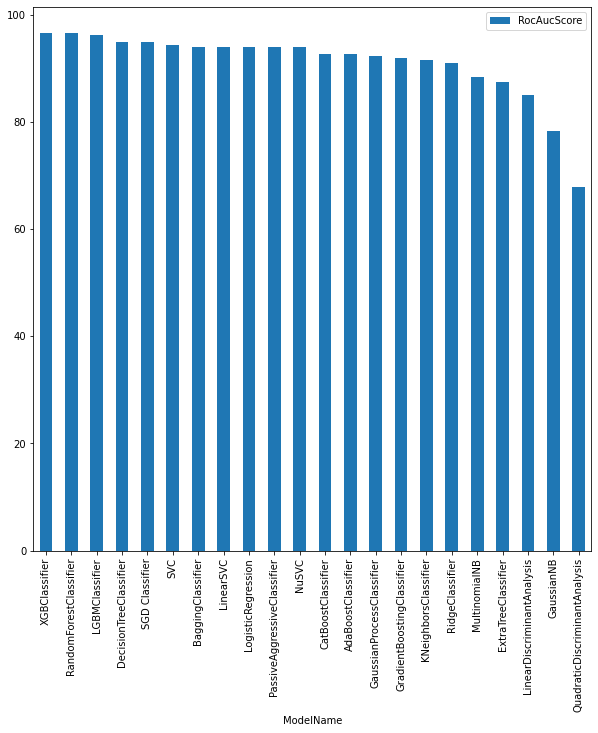

In [61]:
modeldf.plot(x='ModelName', y='RocAucScore', kind='bar',figsize=(10,10))

 Lets try for voting classifier of for XGB, Random Forest and LGBM,

In [62]:
from sklearn.ensemble import VotingClassifier
clf1= XGBClassifier()
clf2= RandomForestClassifier()
clf3= LGBMClassifier()
eclf1 = VotingClassifier(estimators=[
('xgb', clf1), ('rf', clf2), ('lgbm', clf3)], voting='hard')
eclf1.fit(x_train_cv.astype('float32'), y_train)
predictions = eclf1.predict(x_test_cv.astype('float32'))
roc_auc_score(y_test,predictions)

[14:45:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9615670532262861

There is no signifcant change in roc_auc_score, lets try hyperparameter tuning.

### Hyperparameter Tuning

#### Hyperparameter tuning of Random Forest:

In [28]:
from sklearn.model_selection import GridSearchCV
# parameter grid for values to be tuned
param_grid = {
    'criterion' : ['gini','entropy'],
    'bootstrap': [True,False],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1,5,3],
    'min_samples_split': [1,2],
    'n_estimators': [100,50,190]
}

#Model to be tuned
rf = RandomForestClassifier() 
#Calling GridSearch
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          verbose=1, cv = 5, n_jobs = -1, scoring='roc_auc')
grid_search.fit(x_train_cv, y_train) #fit

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [26]:
grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', n_estimators=190)

In [27]:
rf=RandomForestClassifier(max_features='sqrt', n_estimators=190)

In [33]:
#fit and predict
rf.fit(x_train_cv,y_train)
pred_rf=rf.predict(x_test_cv)
roc_auc_score(y_test,pred_rf)

0.9529438001784122

#### Hyperparameter tuning of XGBoost:

In [29]:
param_grid={
 "learning_rate"    : [0.05, 0.10, 0.20, 0.30 ] ,
 "max_depth"        : [ 3, 5, 8, 12, 15],
 "min_child_weight" : [ 1, 3, 7 ],
 "gamma"            : [ 0.0, 0.2 , 0.5 ],
 "colsample_bytree" : [ 0.3, 0.5, 1 ]
    }

#Model to be tuned
xgb = XGBClassifier()
#Calling GridSearch
grid_search1 = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          verbose=1, cv = 5, n_jobs = -1, scoring='roc_auc')

grid_search1.fit(x_train_cv, y_train) #fit

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[01:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [30]:
grid_search1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
xg=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xg.fit(x_train_cv,y_train)
pred_xg=xg.predict(x_test_cv)
roc_auc_score(y_test,pred_xg)

[13:01:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9612696996729112

#### Hyperparameter tuning of LGBM:

In [32]:
param_grid={'num_leaves': [10,31], 
             'min_child_samples': [100,20,500], 
             'min_child_weight': [1e-5, 1, 1e1, 1e2], 
             'colsample_bytree': [0.4,0.9],
             'reg_alpha': [0, 1e-1, 10,100],
             'reg_lambda': [0, 1e-1,100]
            }
#Model to be tuned
lgbm = LGBMClassifier()
#Calling GridSearch
grid_search2 = GridSearchCV(estimator = lgbm, param_grid = param_grid, 
                          verbose=1, cv = 5, n_jobs = -1, scoring='roc_auc')

grid_search2.fit(x_train_cv.astype('float32'), y_train) #fit

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.9],
                         'min_child_samples': [100, 20, 500],
                         'min_child_weight': [1e-05, 1, 10.0, 100.0],
                         'num_leaves': [10, 31], 'reg_alpha': [0, 0.1, 10, 100],
                         'reg_lambda': [0, 0.1, 100]},
             scoring='roc_auc', verbose=1)

In [33]:
grid_search2.best_estimator_

LGBMClassifier(colsample_bytree=0.9, min_child_weight=1, reg_alpha=0.1,
               reg_lambda=0.1)

In [31]:
lgbm=LGBMClassifier(colsample_bytree=0.9, min_child_weight=1, reg_alpha=0.1,
               reg_lambda=0.1)
lgbm.fit(x_train_cv.astype('float32'),y_train)
pred_lgbm=lgbm.predict(x_test_cv.astype('float32'))
roc_auc_score(y_test,pred_lgbm)

0.9614183764495986

#### Plotting ROC Curves for all tuned models

In [29]:
predictedValues={'Random Forest':pred_rf,'XGBoost':pred_xg,'LGBM':pred_lgbm}

for i, (name,predVal) in enumerate(predictedValues.items()):
    
    fpr, tpr, threshold = roc_curve(y_test, predVal)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic for {}'.format(name))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

NameError: name 'pred_rf' is not defined

<b>Hyperparameter tuning did not bring a signficant change, the roc_auc_score range was between 95.5-96.5 throughout, <br>
However there was consistency observed in parameters of RandomForestClassifier and,it showed least False Positive rate. <br>
So, going ahead with Random Forest Classifier.

## Saving final model and vectorizer

In [66]:
import pickle
pickle.dump(cv,open('vectorizer.pkl','wb'))
pickle.dump(rfc,open('model.pkl','wb'))